In [1]:
import os
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sqlalchemy import create_engine, text

from GLA import GaussianDiscriminantAnalysis
from Regression import LogisticRegression

In [2]:
load_dotenv()
conn_str = os.getenv('DB_CONNECTION_STRING')

In [3]:
engine = create_engine(conn_str)
stored_procedure = text('EXEC GetCancerTable')

with engine.connect() as connection:
    result = connection.execute(stored_procedure)
    BreastCancer_df = pd.DataFrame(result.fetchall())

In [4]:
BreastCancer_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [5]:
from sklearn.model_selection import train_test_split

X, y = BreastCancer_df.drop('Diagnosis', axis=1).astype(float), BreastCancer_df['Diagnosis'].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=46, test_size=0.2)

---
Class Prior
$$ 
p(y) = \phi^y(1 − \phi)^{1−y}
$$
Probability density of x given y is 0
$$
p(x|y = 0) = \frac{1}{2π^{d/2}|Σ|^{1/2}}exp\left(-\frac{1}{2}(x − µ_0)^TΣ^{−1}(x − µ_0)\right)
$$
Probability density of x given y is 1
$$
p(x|y = 1) = \frac{1}{2π^{d/2}|Σ|^{1/2}}exp\left(-\frac{1}{2}(x − µ_0)^TΣ^{−1}(x − µ_0)\right)
$$

### Parameters
---
When Fitting the data we use these equations to get out parameter (mean, class prior probability and the Convarience)

#### phi or The prior probability
$$
\phi = \frac{1}{n}\sum_{i=1}^n1\{y^{(i)} = 1\}
$$
#### mu or mean
$$
µ_0 = \frac{\sum_{i=1}^n1\{y^{(i)} = 0\}x^{(i)}}{\sum_{i=1}^n1\{y^{(i)} = 0\}}
$$
$$
µ_1 = \frac{\sum_{i=1}^n1\{y^{(i)} = 1\}x^{(i)}}{\sum_{i=1}^n1\{y^{(i)} = 1\}}
$$
#### Sigma or Covarience
$$
Σ = \frac{1}{n}\sum_{i=1}^n(x^{(i)}-µ_{y^{(i)}})(x^{(i)}-µ_{y^{(i)}})^{T}
$$

In [6]:
GLA_Init = GaussianDiscriminantAnalysis()
GLA_Init.fit(X_train, y_train)

### Prediction
---
Using what we acquire as parameters (mean class prior and covarience) we use those for getting the probability density of each class 

##### Probability density of x given y is 0
$$
p(x|y = 0) = \frac{1}{2π^{d/2}|Σ|^{1/2}}exp\left(-\frac{1}{2}(x − µ_0)^TΣ^{−1}(x − µ_0)\right)
$$
##### Probability density of x given y is 1
$$
p(x|y = 1) = \frac{1}{2π^{d/2}|Σ|^{1/2}}exp\left(-\frac{1}{2}(x − µ_0)^TΣ^{−1}(x − µ_0)\right)
$$

##### Log-Likelihood for Class 0:

$$
\log p(x|y=0) = -\frac{1}{2}(\log|Σ|+(x-µ_0)^{T}Σ^{-1}(x-µ_0)+n\log 2π)
$$

##### Log-Likelihood for Class 1:

$$
\log p(x|y=1) = -\frac{1}{2}(\log|Σ|+(x-µ_1)^{T}Σ^{-1}(x-µ_1)+n\log 2π)
$$


##### If decided to use log-likelihood
---
$$
p(x|y) = e^{\log p(x|y)}
$$


### Bayes rule
---
$$
arg\;max_y\;{p(y|x)} = arg\;max_y\;p(x|y)p(y)
$$

In [7]:
GLA_pred = GLA_Init.predict(X_test)

#### Using logistic Regression

In [ ]:
LogRegInit = LogisticRegression(learning_rate=0.01, n_iter=10000)
LogRegInit.fit(X_train, y_train)
LogReg_pred = LogRegInit.predict(X_test)

In [9]:
np.unique_counts(LogReg_pred == y_test)

UniqueCountsResult(values=array([False,  True]), counts=array([  5, 109]))

In [10]:
np.unique_counts(GLA_pred == y_test)

UniqueCountsResult(values=array([False,  True]), counts=array([  5, 109]))

### Visualization of GDA
---

The figure shows the training set and the contours of two Gaussian distributions fitted to each class. The contours have the same shape and orientation because the two distributions share a common covariance matrix (Σ), but they have different means (µ₀ and µ₁).

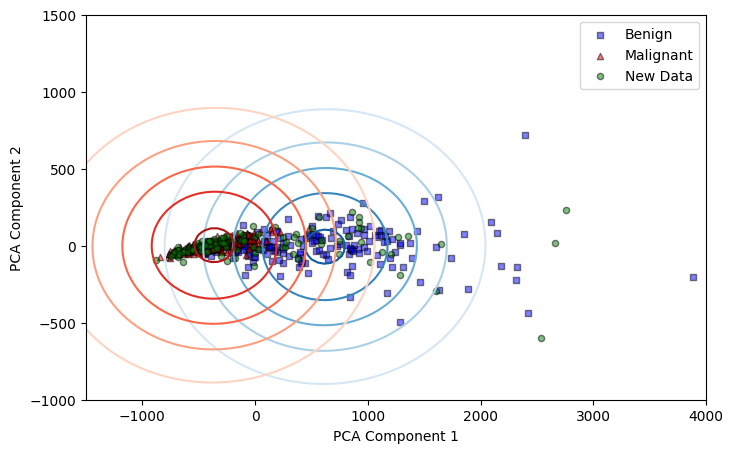

In [11]:
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal

# Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

pca_test = PCA(n_components=2)
X_pca_test = pca_test.fit_transform(X_test)

GLA_Init_new = GaussianDiscriminantAnalysis()
GLA_Init_new.fit(X_pca, y_train)

# Create a grid of points for the contour plot
x = np.linspace(-1500, 4000, 100)
y_grid = np.linspace(-1000, 1500, 100)
X_grid, Y_grid = np.meshgrid(x, y_grid)
pos = np.dstack((X_grid, Y_grid))

# Evaluate the PDF for benign and malignant
rv_benign = multivariate_normal(GLA_Init_new.Mu[0], GLA_Init_new.sigma)
Z_benign = rv_benign.pdf(pos)

rv_malignant = multivariate_normal(GLA_Init_new.Mu[1], GLA_Init_new.sigma)
Z_malignant = rv_malignant.pdf(pos)

# Scatter plot of the two PCA components
plt.figure(figsize=(8,5))

# Contour plot for benign class
plt.contour(X_grid, Y_grid, Z_benign, levels=5, cmap='Blues')

# Contour plot for malignant class
plt.contour(X_grid, Y_grid, Z_malignant, levels=5, cmap='Reds')

plt.scatter((X_pca.T[0])[y_train == 0], (X_pca.T[1])[y_train == 0], color='blue', marker="s",label='Benign' ,s=20,  alpha=0.5, edgecolors='k')
plt.scatter((X_pca.T[0])[y_train == 1], (X_pca.T[1])[y_train == 1], color='red',marker="^", label='Malignant', s=20, alpha=0.5, edgecolors='k')
plt.scatter(X_pca_test.T[0], X_pca_test.T[1], color='green',marker="o", label='New Data', s=20, alpha=0.5, edgecolors='k')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()